###  Дмитрий МАРЬИН - проект RDS_06 - группа dspr-48    

#### <span style="color: LightSeaGreen;"> Юнит 5. Основные алгоритмы машинного обучения. Часть I  Проект 5. Итоговый вызов (**RDS_06**) </span>

#### <span style="font-size: 12pt; color: Indigo; font-weight: bold;">[SF-DST] Credit Scoring </span>[ Прогнозирование вероятности дефолта заемщика -  www.kaggle.com](https://www.kaggle.com/c/sf-dst-scoring)  
______________________

### оглавление <span style="font-size: 10pt; color: green;">(кликабельно)</span>   

- #### [цели и задачи проекта](#goals)
- #### [файлы и датасеты](#files)  
- #### [просмотр исходных данных](#raw_data_check) 
- #### [разбивка данных по типам](#data_split)  
- #### [анализ и подготовка количественных данных](#data_split)  
- #### [корреляция количественных признаков](#num_corr)  
- #### [осмотр категориальных признаков](#cat_review) 
- #### [оценка значимости категоральных признаков](#cat_weight)
- #### [итоги осмотра и подготовки данных](#data_summary)
- #### [отбор признаков для модели и train_test_split](#tt_split)  
- #### [выбор метрик](#metrics_1) 
- #### [пробная модель (Naive Model) модель-1](#naive_model)  
- #### [class weight 'balanced'- модель-2](#model_2)  
- #### [эксперименты с данными и feature engineering - итоги](#fe)  
- #### [SMOTE over-sampling - model-3](#smote)
- #### [подбор гиперпараметров](#hyper)
- #### [подготовка файлов к submission](#submission)
- #### [список литературы](#lit)
- #### [ссылки](#links)   

### цели и задачи проекта  <a name="goals"></a>  

по параметрам заемщика оценить вероятнось дефолта для принятие решения от кредите  
базовая модель - **логистическая регрессия**  
[описание на kaggle/com](https://www.kaggle.com/c/sf-dst-scoring)  
оценка модели - **ROC AUC** (kagle dest scores **> 0.74)**  
при этом может быть много FP случаев - надо найти баланс

### [файлы](https://www.kaggle.com/c/sf-dst-scoring/data) и используемые датасеты  <a name="files"></a>  

### просмотр исходных данных  <a name="raw_data_check"></a>   

|# |Аттрибут  |Описание аттрибута:  |
|--|----------|---------------------|
|01|client_id|идентификатор клиента|
|02|education|уровень образования
|03|sex|пол заёмщика|
|04|age|возраст заёмщика|
|05|car|флаг наличия автомобиля|
|06|car_type|флаг автомобиля-иномарки|
|07|decline_app_cnt|количество отказанных прошлых заявок|
|08|good_work|флаг наличия «хорошей» работы|
|09|bki_request_cnt|количество запросов в БКИ|
|10|home_address|категоризатор домашнего адреса|
|11|work_address|категоризатор рабочего адреса|
|12|income|доход заёмщика|
|13|foreign_passport|наличие загранпаспорта|
|14|sna|связь заемщика с клиентами банка|
|15|first_time|давность наличия информации о заемщике|
|16|score_bki|скоринговый балл по данным из БКИ|
|17|region_rating|рейтинг региона|
|18|app_date|дата подачи заявки|
|19|default|наличие дефолта => TARGET|  

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score,
    roc_auc_score, roc_curve, RocCurveDisplay,
    classification_report, 
    confusion_matrix, ConfusionMatrixDisplay, 
    precision_recall_curve, PrecisionRecallDisplay)
import imblearn
from imblearn.over_sampling import SVMSMOTE, BorderlineSMOTE, SVMSMOTE
r_s = 42 # my random state

In [2]:
# моя оценка точности предсказаний модели
def my_score():
    total_records = y_test.size
    real_def = np.sum(y_test == 1)
    real_good = np.sum(y_test == 0)
    total_pred_def = np.sum(y_pred == 1)
    c_m = confusion_matrix(y_test, y_pred) # create confusion matrix
    TP_pred_good = c_m[0, 0]
    TN_pred_def = c_m[1, 1]
    FP_pred_good = c_m[1, 0]
    FN_pred_def = c_m[0, 1]
    print(
        os.linesep,
        'TOTAL RECORDS in train = ', total_records, os.linesep,
        'real Defaults total = ', real_def, os.linesep,
        'predicted Defaults total = ', total_pred_def, os.linesep,
        'correct Default prediction (TN) = ', TN_pred_def, os.linesep,
        'wrong Default prediction (FN) = ', FN_pred_def, os.linesep,
        'wrong positive prediction (FP) = ', FP_pred_good, os.linesep,
        'то есть  из ', real_def, 
        'дефолтов модель корректно предсказала ', TN_pred_def, os.linesep,
        'что составляет = ', f'{(TN_pred_def/real_def):.1%}', os.linesep)
    my_recall = recall_score(y_test, y_pred).round(2)
    my_precision = precision_score(y_test, y_pred).round(2)
    my_roc_auc_score = roc_auc_score(y_test, y_pred).round(2)
    my_f1_score = f1_score(y_test, y_pred).round(2)
    my_fbeta_score = fbeta_score(y_test, y_pred, beta=0.7).round(2)
    my_accuracy_score = accuracy_score(y_test, y_pred).round(2)
    print(
        '\nRecall (most important for me) = ', '\033[1m', my_recall, '\033[0m',
        '\nPrecision = ', my_precision, 
        '\nF1 score = ', my_f1_score,
        '\nF beta (0.7) score =', my_fbeta_score,
        '\nAccuracy score = ', my_accuracy_score,
        '\nROC AUC = ', my_roc_auc_score,
        '\n')

def show_roc_auc_graph(): # смотрим на ROC AUC
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

def show_conf_matrix(): # plot confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
        ("Normalized confusion matrix", "true"),]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            model, X_test, y_test, display_labels=None,
            cmap=plt.cm.Blues, normalize=normalize, )
        disp.ax_.set_title(title)
        print(title)
        print(disp.confusion_matrix)
    plt.show()  

In [3]:
# для работы с данными берем ТОЛЬКО train.csv => df
df = pd.read_csv("train.csv")

In [4]:
# проверка наличия дубликатов
if len(df)>len(df.drop_duplicates()):
    print('Duplicated found:')
    display(df[df.duplicated()])
else:
    print('No duplicates')

No duplicates


In [5]:
# таблица отсутствующих данных по столбцам
mv = df.isnull().sum()
mvp = 100 * df.isnull().sum() / len(df)
mv_table = pd.concat([mv, mvp], axis=1)
mv_table2 = mv_table.rename(columns = {0 : 'NaN', 1 : '% NaN'})
mv_table2 = mv_table2[mv_table2.iloc[:,1] >= 0].round(1)
print(mv_table2)

                  NaN  % NaN
client_id           0    0.0
app_date            0    0.0
education         307    0.4
sex                 0    0.0
age                 0    0.0
car                 0    0.0
car_type            0    0.0
decline_app_cnt     0    0.0
good_work           0    0.0
score_bki           0    0.0
bki_request_cnt     0    0.0
region_rating       0    0.0
home_address        0    0.0
work_address        0    0.0
income              0    0.0
sna                 0    0.0
first_time          0    0.0
foreign_passport    0    0.0
default             0    0.0


In [6]:
df['education'].value_counts(dropna=False)

SCH    38860
GRD    23365
UGR     9816
PGR     1257
NaN      307
ACD      194
Name: education, dtype: int64

#### категориальный признак 'education' сразу преобразуем в ординарный, уберем n/a
- замена пустых на 'not_filled'
- категориальный преобразуем в ординарный (not_filled < SCH < UGR < GRD < PGR < ACD)

In [7]:
df['education'].fillna("not_filled", inplace=True)
edu_dict = {'not_filled': 0, # set category order
            'SCH': 1,
            'UGR': 2,
            'GRD': 3,
            'PGR': 4,
            'ACD': 5}
df['education'] = df.education.map(edu_dict) # encoding

#### разделим данные по типам   <a name="data_split"></a>   
+ целевая переменная = default
+ бесполезные (2)- app_date, client_id
+ числовые (6) - age, decline_app_cnt, score_bki, bki_request_cnt, income, first_time
+ бинарные (5) - sex, car,  car_type, good_work, foreign_passport
+ категориальные прочие (5) - education, region_rating, home_address, work_address, sna

In [8]:
# количественные (числовые):
num_cols = ['age', 'decline_app_cnt', 'score_bki', 
            'bki_request_cnt',  'income', 'first_time']
# номинативные бинарные:
bin_cols = ['sex', 'car',  'car_type', 'good_work', 'foreign_passport',]
# категориальные (номинативные не бинарные):
cat_cols = ['education', 'region_rating', 
            'home_address', 'work_address', 'sna']

#### анализ и подготовка количественных данных   <a name="num_review"></a> 

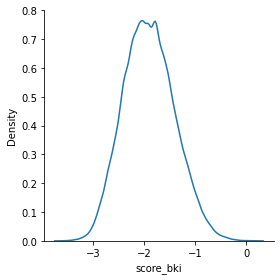

In [9]:
sns.displot(df, x="score_bki", kind="kde", bw_adjust=0.8, height=4, aspect=1)

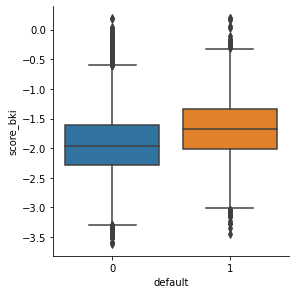

In [10]:
sns.catplot(x="default", y="score_bki", kind="box", data=df, height=4)

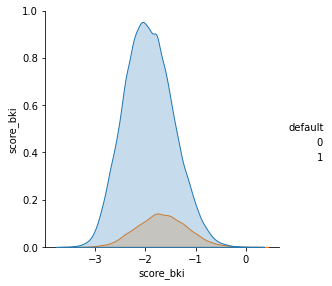

In [11]:
my_col = ['score_bki', 'default']
sns.pairplot(df[my_col], hue = 'default', kind='reg', height=4);

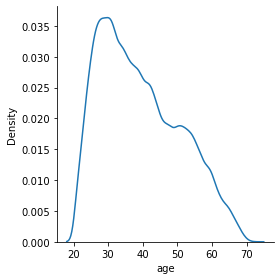

In [12]:
sns.displot(df, x="age", kind="kde", bw_adjust=0.8, height=4)

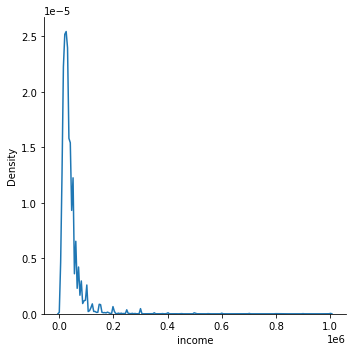

In [13]:
sns.displot(df, x="income", kind="kde", bw_adjust=0.4, height=5)

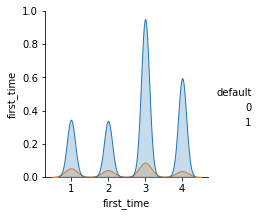

In [14]:
my_col = ['first_time', 'default']
sns.pairplot(df[my_col], hue = 'default', kind='reg', height=3);

#### смотрим на диаграммы размаха (boxplot) количественных признаков

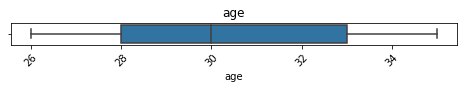

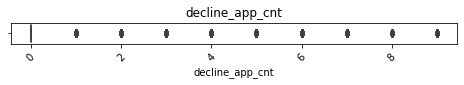

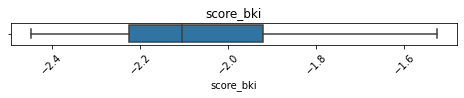

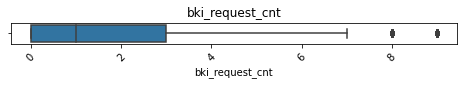

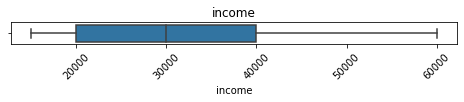

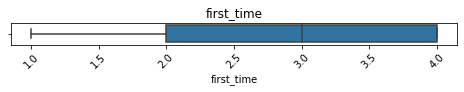

In [15]:
def show_boxplot(column):
    fig, ax = plt.subplots(figsize = (8, 0.4))
    sns.boxplot(x=column, 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title(column)
    plt.show()
for col in num_cols:  
    show_boxplot(col)

#### смотрим на гистограммы количественных признаков

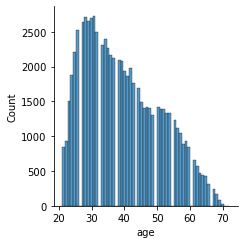

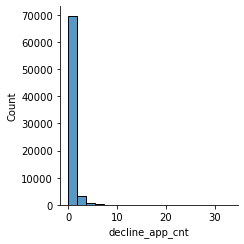

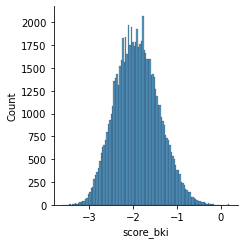

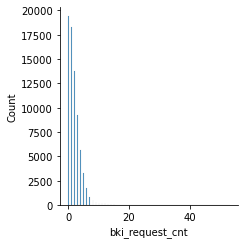

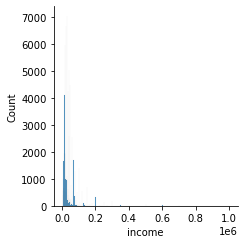

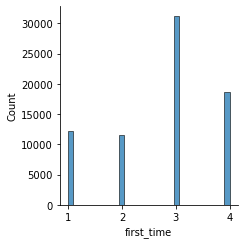

In [16]:
def show_displot(column):
    sns.displot(df, x=column, kind="hist", height=3.5)
for col in num_cols:  
    show_displot(col)

#### вывод - все количественные признаки следует логарифмировать кроме 'score_bki'

In [17]:
# логарифмируем => натуральный (основание 2,72)
df_before_log = df.copy()
log_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
for i in log_cols:
    df[i] = np.log1p(df[i]) # to avoid problems using log(x+1)

проверил - разные значения основания логарифма (1,6, 2, 10) на метрики не влияют

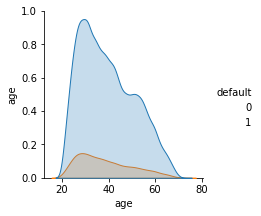

In [18]:
my_col = ['age', 'default'] # 'age' до логарифмирования
sns.pairplot(df_before_log[my_col], hue = 'default', kind='reg', height=3)

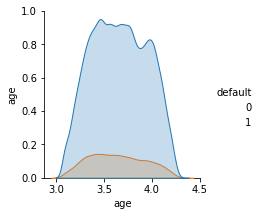

In [19]:
my_col = ['age', 'default'] # 'age' ПОСЛЕ логарифмирования
sns.pairplot(df[my_col], hue = 'default', kind='reg', height=3)

после логарифмирования выглядит гораздо лучше

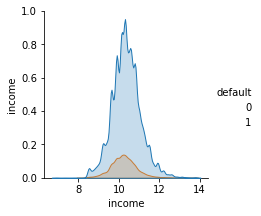

In [20]:
my_col = ['income', 'default']
sns.pairplot(df[my_col], hue = 'default', kind='reg', height=3)

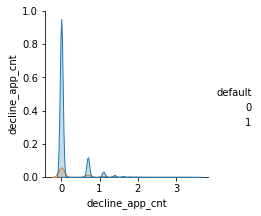

In [21]:
my_col = ['decline_app_cnt', 'default']
sns.pairplot(df[my_col], hue = 'default', kind='reg', height=3)

#### корреляция количественных признаков  <a name="num_corr"></a> 

In [22]:
df_num = df[num_cols]
df_m = df_num.corr(method ='spearman')
df_m.round(2)

,age,decline_app_cnt,score_bki,bki_request_cnt,income,first_time
age,1.00,-0.12,-0.11,0.05,-0.10,0.11
decline_app_cnt,-0.12,1.00,0.20,0.11,-0.01,-0.08
score_bki,-0.11,0.20,1.00,0.13,0.01,-0.08
bki_request_cnt,0.05,0.11,0.13,1.00,0.07,0.01
income,-0.10,-0.01,0.01,0.07,1.00,0.15
first_time,0.11,-0.08,-0.08,0.01,0.15,1.00


вывод - существенной корреляция **между** количественными признаками **нет**  
есть небольшая корреляция (0.20) между 'score_bki' и 'decline_app_cnt'

In [23]:
# корреляция с целевым признаком
df_num2 = df[num_cols + ['default']]
df_m = df_num2.corr(method ='spearman')
most_correlated = df_m.abs()['default'].sort_values(ascending=False)
print(most_correlated.head(10).round(2))

default            1.00
score_bki          0.17
decline_app_cnt    0.12
first_time         0.11
bki_request_cnt    0.08
income             0.06
age                0.03
Name: default, dtype: float64


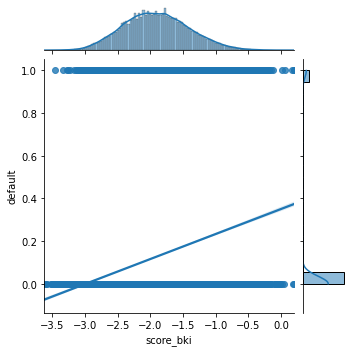

In [24]:
sns.jointplot(x="score_bki", y="default", 
              height=5, dropna=True, data=df, kind='reg', )

#### из ЧИСЛОВЫХ признаков наибольшую корреляцию С ЦЕЛЕВЫМ имеет 'score_bki' (0.17) 

Чем **выше** значение f-статистики, тем меньше вероятность того, что средние значения не отличаются,  
и **тем важнее данный признак** для нашей линейной модели.

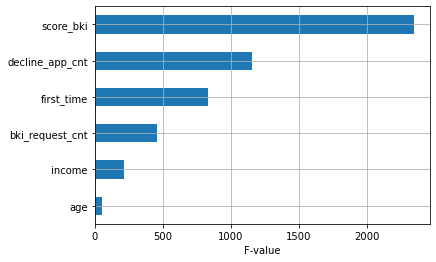

In [25]:
# ANOVA F-test
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh',grid=True)
plt.xlabel('F-value')
plt.show()

#### осмотр категориальных признаков  <a name="cat_review"></a> 

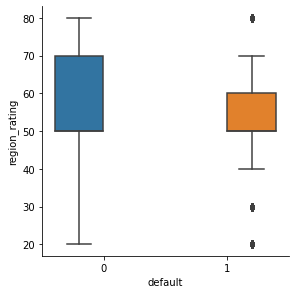

In [26]:
sns.catplot(x="default", y="region_rating", 
            hue="default", kind="box", data=df,  height=4)

In [27]:
# Т-тест для номинативных столбцов
from itertools import combinations
from scipy.stats import ttest_ind

def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'default'], 
                        df.loc[df.loc[:, column] == comb[1], 'default']
                    ).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки = ', 
                  column)
            break
for col in cat_cols:   
    get_stat_dif(col)            

Найдены статистически значимые различия для колонки =  education
Найдены статистически значимые различия для колонки =  region_rating
Найдены статистически значимые различия для колонки =  home_address
Найдены статистически значимые различия для колонки =  work_address
Найдены статистически значимые различия для колонки =  sna


In [28]:
# encoding binary to 0 or 1
m_f_dict ={'M': 1, 'F': 0} # M/F values converted to 1/0
df.sex = df.sex.map(m_f_dict)

y_n_dict = {'Y': 1, 'N': 0} # Y/N values converted to 1/0
for col in ['car', 'car_type', 'foreign_passport']:
    df[col] = df[col].map(y_n_dict)

#### оценка значимости категоральных признаков   <a name="cat_weight"></a> 
с помощью функции **mutual_info_classif**  
"relies on nonparametric methods based on entropy estimation from **k-nearest neighbors** distances"  
n_neighbors=3 (default) 

<AxesSubplot:>

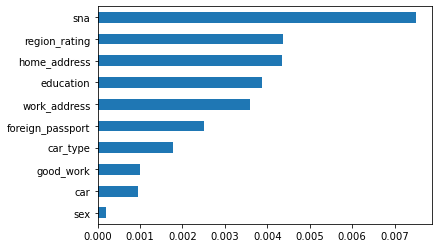

In [29]:
imp_cat = pd.Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'],
                                     discrete_features =True,
                                      n_neighbors=3 ), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [30]:
ratio = (df.default.value_counts()[1] / df.shape[0]).round(2)
print('доля дефолтных клиентов в выборке = ', ratio)

доля дефолтных клиентов в выборке =  0.13


### итоги осмотра и подготовки  данных     <a name="data_summary"></a> 

age, decline_app_cnt, bki_request_cnt, income, first_time - прологорифмированы  
score_bki - без изменений  
sex, car,  car_type, good_work, foreign_passport - в бинарные (1 и 0)  
education - преобразован в ординарный (от 0 до 5)  
**целевая переменная разбалансирована** (дефолтных лишь 13%)

#### отбор признаков для модели и train_test_split   <a name="tt_split"></a>   

In [31]:
# из <df> - объединяем все обработанные признаки для модели в array <X>
X = np.hstack([df[num_cols].values, df[bin_cols].values, df[cat_cols].values])
# правильные предсказания из <df> кладем в array <y>
y = df['default'].values # реальные значения целевого признака для проверки
# обработанные признаки <X> и правильные предсказания <y> 
# делим на две части (80% и 20%)
# 1 обучающая часть <X_train>, <y_train> 
# 2 часть для проверки: 
# - признаки которые модель не видела <X_test>
# - правильные результаты предсказания <y_test>
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)
print(
    X_train.shape[0] + X_test.shape[0], 
    y_train.shape[0] + y_test.shape[0]) # to be sure

73799 73799


### выбор метрик     <a name="metrics_1"></a>   
используются: **f1_score, accuracy_score, roc_curve, roc_auc_score**,  

кроме того для классификации особенно ценна **confusion matrix**  

mean_squared_error для бинарной классификации не подходит

Исходя из того, что убытки от одного дефолтного клиента примерно равны доходу от 10 благополучных заёмщиков, то основной задачей модели будет распознование **максимального** процента дефолтных клиентов, даже ценой ошибочного отсева некоторой доли благополучных заёмщиков.  
Поэтому наиболее важными метриками будут:  
- **Recall** в сочетании с Precision и **F1**  
или F beta, где beta будет в диапазоне 0.5 - 0.9 (?)


### пробная модель (Naive Model): модель-1  <a name="naive_model"></a>   

[off docs sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)   
```
# list of default values:
sklearn.linear_model.LogisticRegression(
penalty='l2', C=1.0, class_weight=None, solver='lbfgs', max_iter=100)
```

In [32]:
# обучаем пробную модель-1
model = LogisticRegression(
    penalty='l2', C=1.0, max_iter=500, class_weight=None, solver='liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test) # данные для передачи в метрики

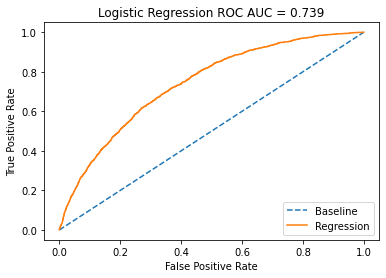


 TOTAL RECORDS in train =  14760 
 real Defaults total =  1827 
 predicted Defaults total =  93 
 correct Default prediction (TN) =  38 
 wrong Default prediction (FN) =  55 
 wrong positive prediction (FP) =  1789 
 то есть  из  1827 дефолтов модель корректно предсказала  38 
 что составляет =  2.1% 


Recall (most important for me) =   0.02  
Precision =  0.41 
F1 score =  0.04 
F beta (0.7) score = 0.06 
Accuracy score =  0.88 
ROC AUC =  0.51 

Confusion matrix, without normalization
[[12878    55]
 [ 1789    38]]
Normalized confusion matrix
[[0.99574731 0.00425269]
 [0.97920088 0.02079912]]


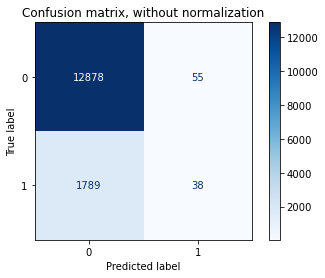

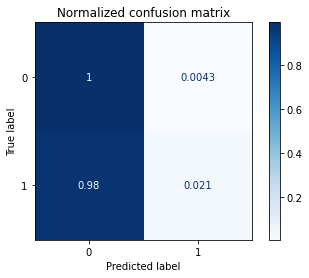

In [33]:
show_roc_auc_graph()
my_score()
show_conf_matrix()

#### оценка модели-1 - неприемлимо:
из 1827 дефолтов модель корректно предсказала 38, что составляет =  2.1%  

основные метрики тоже провальные.  

включим в классификаторе параметр **class_weight='balanced'**  
для балансировки классов  

### модель-2 (class weight 'balanced')  <a name="model_2"></a>   

In [34]:
# обучаем модель-2 (class_weight='balanced')
model = LogisticRegression(
    penalty='l2', C=1.0, max_iter=500, 
    class_weight='balanced', solver='liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test) # данные для передачи в метрики

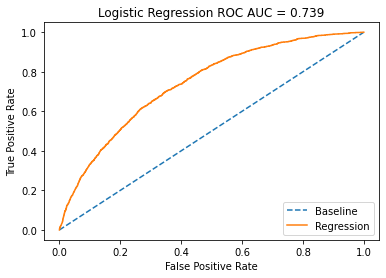


 TOTAL RECORDS in train =  14760 
 real Defaults total =  1827 
 predicted Defaults total =  5546 
 correct Default prediction (TN) =  1238 
 wrong Default prediction (FN) =  4308 
 wrong positive prediction (FP) =  589 
 то есть  из  1827 дефолтов модель корректно предсказала  1238 
 что составляет =  67.8% 


Recall (most important for me) =   0.68  
Precision =  0.22 
F1 score =  0.34 
F beta (0.7) score = 0.29 
Accuracy score =  0.67 
ROC AUC =  0.67 

Confusion matrix, without normalization
[[8625 4308]
 [ 589 1238]]
Normalized confusion matrix
[[0.66689863 0.33310137]
 [0.32238643 0.67761357]]


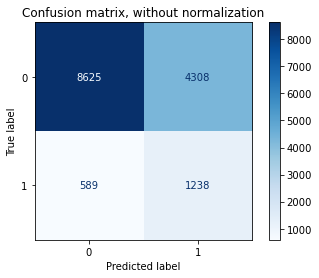

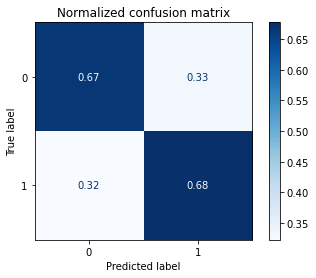

In [35]:
show_roc_auc_graph()
my_score()
show_conf_matrix()

#### оценка модели-2 - лучше первой:
из 1827 дефолтов модель корректно предсказала 1238 
 что составляет =  **67.8%**   
+ Recall = 0.68  - стало лучше
+ Precision = 0.22 - надо улучшить
+ F1 score =  0.34 - надо улучшить

### эксперименты с данными и feature engineering - итоги      <a name="fe"></a>   

было выполнено:  
+ подбор гиперпараметров - метрики не меняются
+ возведение в степень 'score_bki' - тщетно
+ разный one-hot encoding категориальных  - безполезно
+ преобразование car, car_type в количественный - без толку
+ sna - в числовой ординарный - впустую
+ использоввание LogisticRegressionCV - не помогло
+ полностью убираем регуляризацию - попусту
+ fit_intercept = False  - глухо
+ полное удаление всех признаков num, bin, или cat - странно! не влияет вообще!
+ применение StandartScalar для num - напрасно
+ преобразование decline_app_cnt в bin (0 и >0) - втуне
+ new feature = income делёный на age - неудачно
+ decline_app_cnt делёный на age -  безуспешно
+ income делёный или умноженный на sna - никчемно
+ поменял модель - попробовал Logit из модуля Statsmodels - ещё хуже

очень удивило что все эти меры **никак не улучшали метрики**  
поэтому можно заключить, что основная проблема заключается в  
**недостаточном количестве дефолтных клиентов в выборке**  
проверим что даст оверсэмплинг

#### Synthetic Minority Oversampling Technique – SMOTE    <a name="smote"></a>   

существует библиотека **imbalanced-learn**  
с инструментами для подготовки несбалансированных датасетов  
(https://imbalanced-learn.org/stable/references/over_sampling.html)

In [36]:
# в обучающую часть <X_train>, <y_train> добавим значений
# SMOTE process = BorderlineSMOTE
# в модель пойдут: -<X_res>-, -<y_res>-
sm = BorderlineSMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [37]:
# model - LogisticRegression
model = LogisticRegression(
    penalty='l2', C=1.0, max_iter=500, 
    class_weight='balanced', solver='liblinear',
    random_state=r_s)   
# обучаем модель на -<X_res>-, -<y_res>-:
model.fit(X_res, y_res)

LogisticRegression(class_weight='balanced', max_iter=500, random_state=42,
                   solver='liblinear')

In [38]:
# в метрики пойдут:
# отмоделированный из <X_test> <y_pred> 
# проверочные данные: <y_test>
y_pred = model.predict(X_test) # данные для передачи в метрики

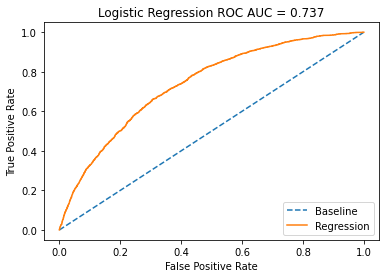


 TOTAL RECORDS in train =  14760 
 real Defaults total =  1827 
 predicted Defaults total =  5291 
 correct Default prediction (TN) =  1215 
 wrong Default prediction (FN) =  4076 
 wrong positive prediction (FP) =  612 
 то есть  из  1827 дефолтов модель корректно предсказала  1215 
 что составляет =  66.5% 


Recall (most important for me) =   0.67  
Precision =  0.23 
F1 score =  0.34 
F beta (0.7) score = 0.29 
Accuracy score =  0.68 
ROC AUC =  0.67 

Confusion matrix, without normalization
[[8857 4076]
 [ 612 1215]]
Normalized confusion matrix
[[0.68483724 0.31516276]
 [0.33497537 0.66502463]]


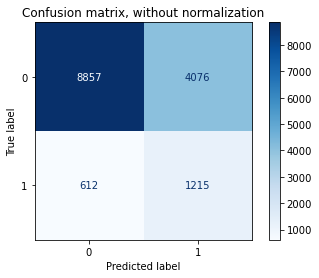

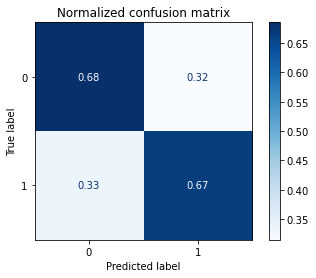

In [39]:
show_roc_auc_graph()
my_score()
show_conf_matrix()

в разных вариантах результаты примерно одинаковые:  
SMOTE  
Recall 0.57, Precision 0.26, F1 0.35, Accuracy 0.74, ROC AUC 0.67  

BorderlineSMOTE  
Recall 0.67, Precision 0.23, F1 0.34, Accuracy 0.68, ROC AUC 0.67  

SVMSMOTE  
Recall 0.57, Precision 0.26, F1 0.35, Accuracy 0.74, ROC AUC 0.67 

#### вывод -  over-sampling для моего датасета метрики не улучшает

### подбор гиперпараметров   <a name="hyper"></a>   
Лучшее Penalty: l1, Лучшее C: 2.78  
**метрики не изменились**  
оставим всё как было

### подготовка файлов к submission   <a name="submission"></a> 

соберем код в один кусок

In [40]:
import os
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score,
    roc_auc_score, roc_curve, RocCurveDisplay,
    classification_report, 
    confusion_matrix, ConfusionMatrixDisplay, 
    precision_recall_curve, PrecisionRecallDisplay)
r_s = 42 # my random state
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [41]:
# для обработки признаков объединяем трейн и тест в  << df >>
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0  # add extra column to test - for correct join 
df = df_test.append(df_train, sort=False).reset_index(drop=True)

In [42]:
num_cols = ['age', 'decline_app_cnt', 'score_bki', 
            'bki_request_cnt',  'income', 'first_time']
bin_cols = ['sex', 'car',  'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'region_rating', 
            'home_address', 'work_address', 'sna']
log_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
for i in log_cols:
    df[i] = np.log1p(df[i])
m_f_dict ={'M': 1, 'F': 0} # M/F values converted to 1/0
df.sex = df.sex.map(m_f_dict)
y_n_dict = {'Y': 1, 'N': 0} # Y/N values converted to 1/0
for col in ['car', 'car_type', 'foreign_passport']:
    df[col] = df[col].map(y_n_dict)
df['education'].fillna("not_filled", inplace=True)
edu_dict = {'not_filled': 0, # establish category order
            'SCH': 1,
            'UGR': 2,
            'GRD': 3,
            'PGR': 4,
            'ACD': 5}
df['education'] = df.education.map(edu_dict)

In [43]:
# разделим <df> на train_data для обучения и subm_data для submission
train_data = df.query('sample == 1').drop(['sample'], axis=1)
subm_data = df.query('sample == 0').drop(['sample'], axis=1)

# из <train_data> - объединяем признаки для модели в array <X>
X = np.hstack(
    [train_data[num_cols].values, train_data[bin_cols].values, train_data[cat_cols].values])

# правильные предсказания из <train_data> кладем в array <y>
y = train_data['default'].values

In [44]:
model = LogisticRegression(
    penalty='l2', C=1.0, max_iter=500, 
    class_weight='balanced', solver='liblinear',
    random_state=r_s)   
# обучаем модель на всех размеченных данных <train_data>
model.fit(X, y)

# из <subm_data> - берем признаки для модели в array <X_subm>
X_subm = np.hstack(
    [subm_data[num_cols].values, subm_data[bin_cols].values, subm_data[cat_cols].values])

y_subm = model.predict(X_subm) # получаем результаты для submision
y_subm_prob = model.predict_proba(X_subm)[:,1]

In [45]:
my_submission = pd.DataFrame({'client_id': df_test['client_id'],
                              'default': y_subm_prob})

my_submission.to_csv("submission.csv", index=False)

In [46]:
my_submission.sample(3)

,client_id,default
23693,48656,0.261364
27477,25986,0.225449
1620,39189,0.107678


#### список литературы    <a name="lit"></a> 

+ Джейк ВандерПЛАС Python для сложных задач: наука о данных и машинное обучение 2018
+ ##### [Jake VanderPLAS Python Data Science Handbook (notebook on his site)](https://jakevdp.github.io/PythonDataScienceHandbook/)  
+ ##### [Jake VanderPLAS Python Data Science Handbook (GIT notebook)](https://github.com/jakevdp/PythonDataScienceHandbook/tree/master/notebooks)  
+ Aurélien Géron Hands-On Machine Learning with Scikit-Learn and TensorFlow    
+ Орельен Жерон Прикладное машинное обучение с помощью Scikit-Learn и TensorFlow  
+ Alice Zheng & Amanda Casari  Feature Engineering for Machine Learning
+ ##### [Alice Zheng & Amanda Casari  FE for ML - GIT notebooks](https://github.com/alicezheng/feature-engineering-book)   
+ Wes McKINNEY  Python for Data Analysis  
+ ##### [Wes McKINNEY  Python for Data Analysis - GIT notebook](https://github.com/wesm/pydata-book)  
+ Andreas MULLER & Sarah GUIDO  Introduction to Machine Learning with Python A Guide for Data Scientists   
+ ##### [MULLER -  book code on GIT](https://github.com/amueller/introduction_to_ml_with_python)  

### ссылки  <a name="links"></a> 

##### explanations
[Can anyone explain me StandardScaler?](https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler)  
[Standardization and Min-Max scaling](https://sebastianraschka.com/Articles/2014_about_feature_scaling.html#standardization-and-min-max-scaling)  
[Difference between OrdinalEncoder and LabelEncoder](https://datascience.stackexchange.com/questions/39317/difference-between-ordinalencoder-and-labelencoder/64177#comment69359_64177)   
[How can I one hot encode in Python?](https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python)  
 [Why Using Mean Squared Error(MSE) Cost Function for Binary Classification is a Bad Idea](https://towardsdatascience.com/why-using-mean-squared-error-mse-cost-function-for-binary-classification-is-a-bad-idea-933089e90df7)   
[plot ROC - Receiver Operating Characteristic](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)   
[Нагорный Олег  Линейная регрессия PyTorch](https://nagornyy.me/it/lineinaia-regressiia-pytorch/)  
[Нагорный Олег  Логистическая регрессия в PyTorch](https://nagornyy.me/it/logisticheskaia-regressiia-v-pytorch/)  
 [t-SNE - t-distributed Stohastic Neighbor Embedding](https://habr.com/ru/company/ods/blog/323210/)   
[original article - Guide to Encoding Categorical Values in Python](https://pbpython.com/categorical-encoding.html)   
[перевод статьи по кодированию категориальных значений ](https://dfedorov.spb.ru/pandas/%D0%A0%D1%83%D0%BA%D0%BE%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D0%BE%20%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8E%20%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D1%85%20%D0%B7%D0%BD%D0%B0%D1%87%D0%B5%D0%BD%D0%B8%D0%B9%20%D0%B2%20Python.html)  
[Encoding Categorical  - GIT notebook](https://github.com/chris1610/pbpython/blob/master/notebooks/Category-Encoding-Article.ipynb)  
[Logistic Regression: Scikit Learn vs Statsmodels](https://stats.stackexchange.com/questions/203740/logistic-regression-scikit-learn-vs-statsmodels)  
[Техника переcэмплирования синтетического меньшинства (SMOTE)](https://www.helenkapatsa.ru/smote-pieriesemplirovaniie/)  

##### column transformer   
[sklearn.compose.make_column_transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html)  
[How to Use the ColumnTransformer for Data Preparation](https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/)  
[How to use sklearn Column Transformer?](https://stackoverflow.com/questions/54160370/how-to-use-sklearn-column-transformer)  
[Easier Machine Learning with the New Column Transformer from Scikit-Learn](https://medium.com/vickdata/easier-machine-learning-with-the-new-column-transformer-from-scikit-learn-c2268ea9564c)  

##### official docs   
[sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)  
[sklearn.preprocessing.LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder)   
[sklearn.preprocessing.OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder)   
 [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder)   
[pandas.factorize](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.factorize.html)  [stack - pandas.factorize on an entire data frame](https://stackoverflow.com/questions/39390160/pandas-factorize-on-an-entire-data-frame)   
[sklearn.feature_selection.f_classif - Compute the ANOVA F-value](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html)   
[Feature Selection methods in  sklearn.feature_selection module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)    
значимость категоральных признаков  
[sklearn.feature_selection.mutual_info_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html)   
Estimate mutual information for a **DISCRETE TARGET variable**  
 term “discrete features” is used instead of naming them “categorical”...   
[Metrics and scoring: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html)  
[sklearn.linear_model.LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)  
[sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
[sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)   
[statsmodels.discrete.discrete_model.Logit](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Logit.html)  

